# Elevator Raw Data Processing

### Import Essential Libraries and Dataset

In [45]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [4]:
# import dataset
df_people = pd.read_csv('data\\people.csv')
df_sim = pd.read_csv('data\\simulation.csv')

# data information
df_people.info()
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28957 entries, 0 to 28956
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   action   28957 non-null  object
 1   guest    28957 non-null  bool  
 2   id       28957 non-null  int64 
 3   subject  28957 non-null  object
 4   system   28957 non-null  object
 5   time     28957 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166941 entries, 0 to 166940
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   action      166941 non-null  object 
 1   direction   57915 non-null   object 
 2   floor       166941 non-null  int64  
 3   subject     166941 non-null  object 
 4   system      166941 non-null  object 
 5   time        166941 non-null  object 
 6   weight      109026 non-null  float64
 7   date        166941 non-null  object 
 8   da

### Step 1: Data Cleaning

1. Convert `time` column to datatime in pandas
2. Drop the `date` and `date_daily`  columnns

In [5]:
df_sim['time'] = pd.to_datetime(df_sim['time'])
df_sim.drop(['date', 'date_daily'], axis=1, inplace=True)

df_people['time'] = pd.to_datetime(df_people['time'])


In [6]:
df_sim.head()

,action,direction,floor,subject,system,time,weight
0,call,up,0,system,elevator control,2019-01-01 07:50:53.906554,NaN
1,door open,NaN,0,1,elevator control,2019-01-01 07:50:53.906554,0.000000
2,door open,NaN,2,1,elevator control,2019-01-01 07:51:19.006554,191.487083
3,call,up,0,system,elevator control,2019-01-01 07:54:40.829759,NaN
4,door open,NaN,0,2,elevator control,2019-01-01 07:54:40.829759,0.000000


In [7]:
df_people.head()

,action,guest,id,subject,system,time
0,swiped in,True,112070702136,Charlotta SCHNITTGER,swipe system,2019-01-01 07:50:22.678631
1,swiped in,True,112070356608,Vassie GALARSA,swipe system,2019-01-01 07:54:09.941757
2,swiped in,True,112090458320,Wenzel ERBSTOESSER,swipe system,2019-01-01 08:00:54.406641
3,swiped in,True,112070884320,Rayan SHATTUCK,swipe system,2019-01-01 08:10:02.745435
4,swiped in,True,112071001200,Heath HILLMANN,swipe system,2019-01-01 08:14:58.313058


### Step 2: Explore the data

##### Description

> people.csv documented all of the swipes into the buildings security system
> 
> simulation.csv is a log of each elevator's status and operations, there were total  4 elevators in the 20 story building.

##### Up/Down Calls for the elevator

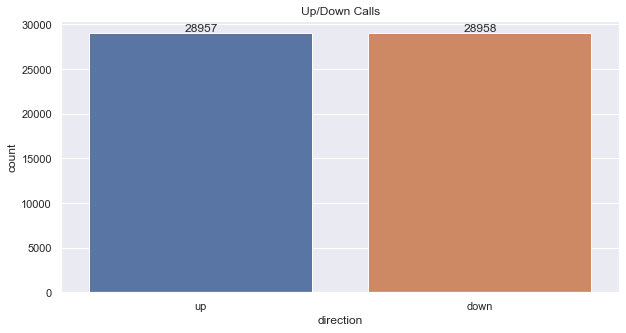

In [8]:
plt1,ax1 = plt.subplots(figsize=(10,5))
ax1 = sb.countplot(df_sim.direction)
ax1.set_title("Up/Down Calls")
for rect in ax1.patches:
    ax1.text(rect.get_x() + rect.get_width()/2, rect.get_height(), rect.get_height(), ha='center', va='bottom')
plt1.show()

Can see the elevator has an almost equal up/down calls in total.

##### Reshaping the data to what we need


In [9]:
df_sim['wait_time']  = np.NaN # create a new column for wait time
df_sim['elevator_id'] = '' # create a new column for elevator id (which elevator arrived)
df_sim["src_floor"] = '' # create a new column for the floor the elevator is coming from

In [10]:
for row in df_sim.itertuples():
    if row.subject == "system":
        forward_search_range = df_sim.iloc[row.Index : row.Index + 100]
        for forward_search_row in forward_search_range.itertuples():
            if (
                row.floor == forward_search_row.floor
                and forward_search_row.action == "door open"
            ):
                result = forward_search_row.time - row.time
                df_sim.loc[row.Index, "wait_time"] = result.seconds
                df_sim.loc[row.Index, "elevator_id"] = forward_search_row.subject
                break
            else:
                continue
        backward_search_range = df_sim.iloc[row.Index :: -1]
        for backward_search_row in backward_search_range.itertuples():
            if (
                backward_search_row.subject == forward_search_row.subject
                and backward_search_row.action == "door open"
            ):
                df_sim.at[row.Index, "src_floor"] = backward_search_row.floor
                break
            else:
                df_sim.at[row.Index, "src_floor"] = row.floor
                continue


In [11]:
df_sim.wait_time.fillna(0,inplace=True)
df_sim.wait_time = df_sim.wait_time.astype(int)

In [12]:
def floors_traveled(x):
    if x.subject == "system":
        result = abs(x.floor - x.src_floor)
        return result
    else:
        return 0


floor_difference = df_sim.apply(floors_traveled, axis=1)
df_sim["floors_traveled"] = floor_difference


In [13]:
# change datafram index to time
df_sim = df_sim.set_index('time')

In [14]:
df_wait_time = df_sim.loc[df_sim['action'] == 'call']
df_wait_time.drop('weight' , axis=1, inplace=True)
df_wait_time

,action,direction,floor,subject,system,wait_time,elevator_id,src_floor,floors_traveled
time,,,,,,,,,
2019-01-01 07:50:53.906554,call,up,0,system,elevator control,0,1,0,0
2019-01-01 07:54:40.829759,call,up,0,system,elevator control,0,2,0,0
2019-01-01 08:01:37.689910,call,up,0,system,elevator control,0,0,0,0
2019-01-01 08:10:29.154320,call,up,0,system,elevator control,0,3,0,0
2019-01-01 08:15:34.082043,call,up,0,system,elevator control,8,2,2,2
...,...,...,...,...,...,...,...,...,...
2019-05-29 21:33:52.172793,call,down,2,system,elevator control,8,1,0,2
2019-05-29 21:38:43.165430,call,down,2,system,elevator control,8,3,0,2
2019-05-29 21:58:30.144980,call,down,15,system,elevator control,60,2,0,15


### Question 1: Is the wait time related to time of the day?

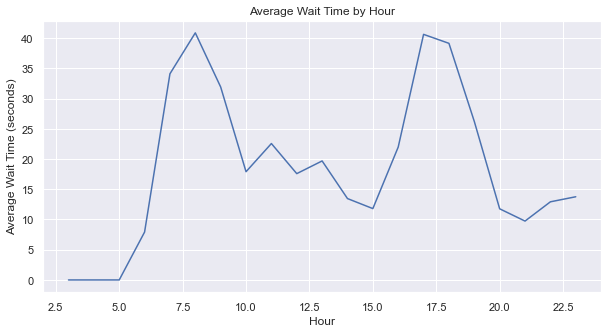

In [15]:
wait_time_time_series = df_wait_time.wait_time.groupby(df_wait_time.wait_time.index.hour).mean()
plt, ax = plt.subplots(figsize=(10,5))
ax = sb.lineplot(data = wait_time_time_series)
ax.set_title("Average Wait Time by Hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Average Wait Time (seconds)")
plt.show()

Conclusion: Can see from the graph, wait time spikes at some specific times during the day.

### Question 2: Is the wait time related to floors?

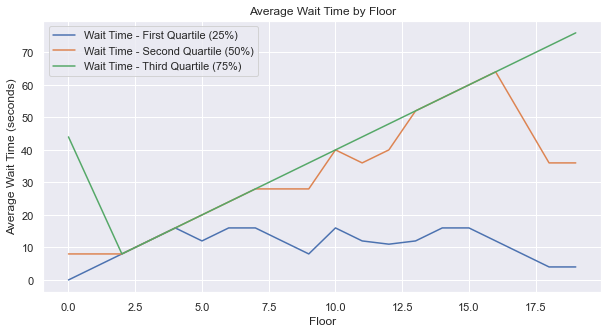

In [18]:
wait_time_q1 = df_wait_time.groupby('floor').wait_time.quantile(.25)
wait_time_q2 = df_wait_time.groupby('floor').wait_time.quantile(.50)
wait_time_q3 = df_wait_time.groupby('floor').wait_time.quantile(.75)

plt, ax = plt.subplots(figsize=(10,5))
ax = sb.lineplot(data = wait_time_q1, label = 'Wait Time - First Quartile (25%)')
ax = sb.lineplot(data = wait_time_q2, label = 'Wait Time - Second Quartile (50%)')
ax = sb.lineplot(data = wait_time_q3, label = 'Wait Time - Third Quartile (75%)')
ax.set_title("Average Wait Time by Floor")
ax.set_xlabel("Floor")
ax.set_ylabel("Average Wait Time (seconds)")
plt.show()

### Feature Importance Discovery

In [34]:
data = df_wait_time
data

,direction,floor,wait_time,elevator_id,src_floor,floors_traveled
time,,,,,,
2019-01-01 07:50:53.906554,up,0,0,1,0,0
2019-01-01 07:54:40.829759,up,0,0,2,0,0
2019-01-01 08:01:37.689910,up,0,0,0,0,0
2019-01-01 08:10:29.154320,up,0,0,3,0,0
2019-01-01 08:15:34.082043,up,0,8,2,2,2
...,...,...,...,...,...,...
2019-05-29 21:33:52.172793,down,2,8,1,0,2
2019-05-29 21:38:43.165430,down,2,8,3,0,2
2019-05-29 21:58:30.144980,down,15,60,2,0,15


In [35]:
data.drop(columns=['action', 'system', 'subject'], inplace = True)
data = pd.get_dummies(data, columns=['direction'], drop_first=True)
data

,floor,wait_time,elevator_id,src_floor,floors_traveled,direction_up
time,,,,,,
2019-01-01 07:50:53.906554,0,0,1,0,0,1
2019-01-01 07:54:40.829759,0,0,2,0,0,1
2019-01-01 08:01:37.689910,0,0,0,0,0,1
2019-01-01 08:10:29.154320,0,0,3,0,0,1
2019-01-01 08:15:34.082043,0,8,2,2,2,1
...,...,...,...,...,...,...
2019-05-29 21:33:52.172793,2,8,1,0,2,0
2019-05-29 21:38:43.165430,2,8,3,0,2,0
2019-05-29 21:58:30.144980,15,60,2,0,15,0


##### Split the data into train-test datasets

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

X = data.drop(['wait_time'], axis=1)
y = data.wait_time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### Scale the data

In [40]:
feature_names = X_train.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Apply L-GBM model

In [41]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }  
lgbm = lgb.LGBMClassifier()
grid = RandomizedSearchCV(lgbm,param_grid ,refit=True,verbose=2)
grid.fit(X_train_scaled, y_train)
y_pred = grid.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[CV] END lambda_l1=1, lambda_l2=0, min_data_in_leaf=30, num_leaves=31, reg_alpha=0.5; total time=   9.9s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[CV] END lambda_l1=1, lambda_l2=0, min_data_in_leaf=30, num_leaves=31, reg_alpha=0.5; total time=   8.0s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. 

In [43]:
# compute and print accuracy score
from sklearn.metrics import accuracy_score
print('Model accuracy score with optimal hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)

Model accuracy score with optimal hyperparameters: 0.8637

 The best estimator across ALL searched params:
 LGBMClassifier(lambda_l1=1, lambda_l2=1, min_data_in_leaf=50, num_leaves=127,
               reg_alpha=0.1)


##### Print sorted feature importance based on importance

In [46]:
lgbm_optimized = lgb.LGBMClassifier(lambda_l1=1, lambda_l2=0, min_data_in_leaf=400, reg_alpha=0.5)
lgbm_optimized.fit(X_train_scaled, y_train)
#refer https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm/notebook#Feature-importance
feature_imp = pd.DataFrame(sorted(zip(lgbm_optimized.feature_importances_, X_train.columns)), columns=['Value','Feature'])


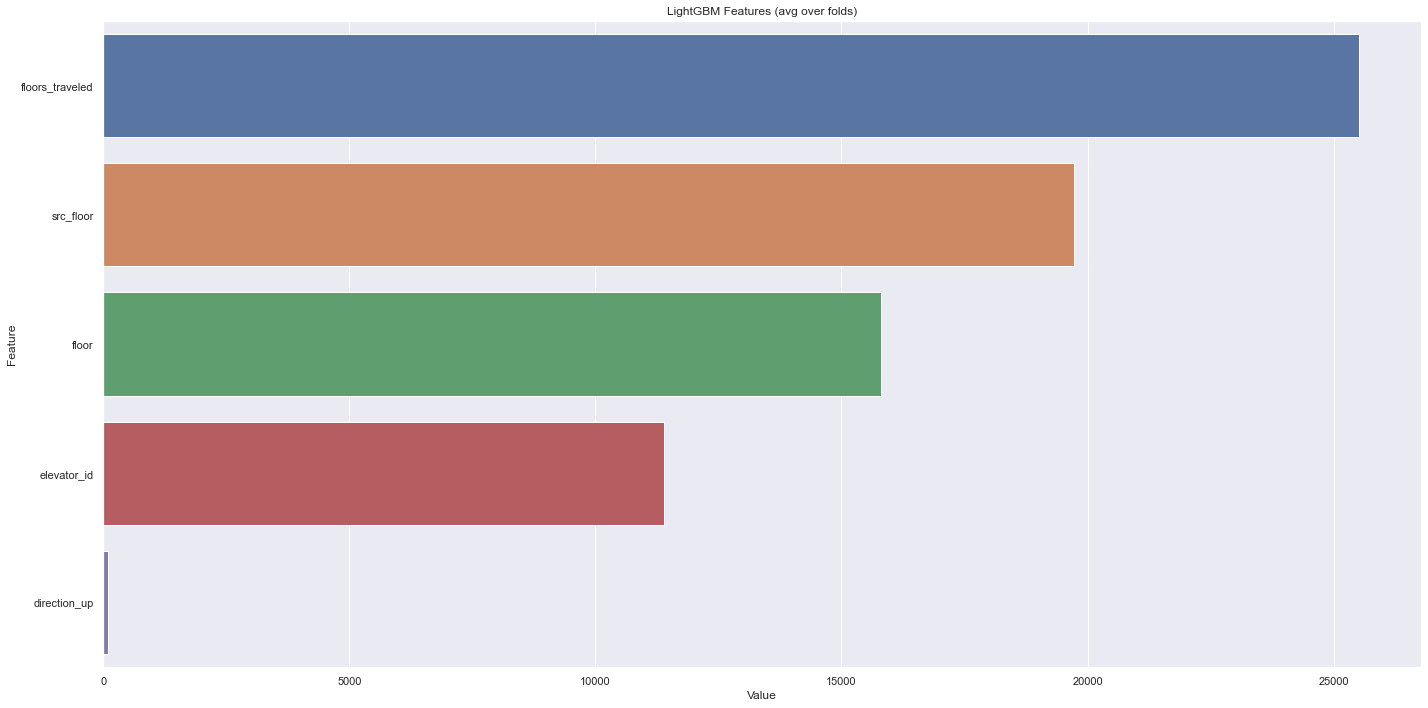

In [47]:
plt.subplots(figsize=(20, 10))
sb.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()